**Dataset, graph config**

In [2]:
import pandas as pd
import logging

logging.basicConfig(filename='wiki_v02.log', filemode='w', level=logging.INFO)

# load full dataset
raw_df = pd.read_csv('data/original/kg3.csv')

# Create node/edge mappings
node_list = pd.concat([raw_df["subject"], raw_df["object"]]).unique()
edge_list = raw_df["relation"].unique()

node_map = dict((node, idx) for idx, node in enumerate(node_list))
edge_map = dict((edge, idx) for idx, edge in enumerate(edge_list))

**Create splits**

In [2]:
import random
from sklearn.model_selection import train_test_split

random_state = 42
random.seed(random_state)

# split data into 70/10/20 train/val/test split
train_df, val_test_df = train_test_split(raw_df, test_size=0.3, random_state=random_state)
val_df, test_df = train_test_split(val_test_df, test_size=0.667, random_state=random_state)

# split train_data into labeled/unlabeled pools
# initially labeled pool has 10% of training triplets
labeled_df, unlabeled_df = train_test_split(train_df, train_size=0.1, random_state=random_state)

**Create `Data` objects**

In [3]:
import torch
from torch_geometric.data import Data

def df_to_data(*dataframes: pd.DataFrame) -> Data:
    """Converts dataframe(s) to data object(s) using node/edge maps."""
    def conversion(dataframe):
        heads = torch.tensor([node_map[term] for term in dataframe["subject"].values])
        rels = torch.tensor([edge_map[rel] for rel in dataframe["relation"].values])
        tails = torch.tensor([node_map[term] for term in dataframe["object"].values])

        #num_nodes = len(torch.unique(torch.concat([heads, tails])))
        #num_edge_types = len(torch.unique(rels))
        edge_index = torch.stack([heads, tails]) 

        data = Data(edge_index=edge_index, 
                    edge_type=rels, 
                    num_nodes=len(node_list), 
                    num_edge_types=len(edge_list)
                )

        return data
    
    return tuple(conversion(dataframe) for dataframe in dataframes)

raw_data, = df_to_data(raw_df)
train_data, val_data, test_data = df_to_data(train_df, val_df, test_df)
labeled_data, unlabeled_data = df_to_data(labeled_df, unlabeled_df)

logging.info("Data splits created.")

**Model**

In [4]:
from torch_geometric.nn import TransE

batch_size = 50
emb_dim = 20

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TransE(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=emb_dim,
).to(device)

loader = model.loader(
        head_index=labeled_data.edge_index[0],
        rel_type=labeled_data.edge_type,
        tail_index=labeled_data.edge_index[1],
        batch_size=batch_size,
        shuffle=True,
    )

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples

@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=batch_size,
        k=10,
        log=False
    )

**Supervised learning**

In [5]:
def supervised_learning():
    """Handles supervised learning. Returns model loss and state (parameters)."""
    loss = train()
    state = model.state_dict()

    logging.info(f'Epoch {epoch:03d} | Loss: {loss:.4f}')
    
    if epoch % 25 == 0:
        rank, hits = test(val_data)
        
        global learning_curve
        learning_curve[epoch]["mean_rank"] = rank 
        learning_curve[epoch]["hits_at_10"] = hits 
        logging.info(f"VALIDATION: Mean Rank = {rank:.2f} | Hits@10 = {hits:.4f}")
            
    return loss, state

def loss_stability_check(cur_loss: float, cur_state, N: int = 10, tolerance: int | float = 0.5) -> None | bool:
    """Check stability of learning loss.
    
    Inputs
        cur_loss (float): current model loss.
        cur_state : current state (parameters) of the model.
        N (int): size of rolling average sample.
        tolerance (int|float): tolerance check for percent error of cur_loss.
    Output
        True if percent error is within tolerance, None otherwise
    """
    global loss_list, state_list
    loss_list.append(cur_loss)
    state_list.append(cur_state)

    if len(loss_list) > N:
        loss_list.pop(0)
        state_list.pop(0)
        
    if len(loss_list) == N:

        std, mean = torch.std_mean(torch.tensor(loss_list))
        cv = std/mean
        err = 1 - cur_loss/mean
        Q1mean = torch.mean(torch.tensor(loss_list[:round(N/2)]))
        Q3mean = torch.mean(torch.tensor(loss_list[round(N/2):]))
        
        # conditions
        cond1 = err < tolerance # cur_loss is close to mean
        cond2 = cv < 0.5 # std is small rel. to mean
        cond3 = abs(1-Q1mean/Q3mean) < tolerance # data is NOT bimodal
        
        if cond1 and cond2 and cond3:

            config = sorted(zip(loss_list, state_list), key=lambda x: x[0])

            best_loss, best_state = config[0]
            
            model.load_state_dict(best_state)
            logging.info("Training stability reached.")
        
            return True

**Querying and updating pools**

In [6]:
import random 
random.seed(random_state)

def prediction(head: torch.tensor, rel: torch.tensor) -> torch.tensor:
    """Takes head, rel -> returns predicted tails sorted by score."""

    num_nodes = len(node_list)
    tails = torch.arange(num_nodes)
    
    pred = enumerate(model.forward(head, rel, tails))
    # sort by score
    sorted_pred = sorted(pred, key=lambda x: x[1], reverse=True)
    
    return sorted_pred

def query_instances(budget: int = 1, method="uncertainty") -> list:
    """Retrieves indices of worst-scoring triplets.
    
    Inputs
        budget (int): Number of queries to make (default: 1).
        method (str): Querying method (default: "uncertainty").

    Output
        List of triplet indices for update_pools(...).
    """
    
    triplet_ranks = {} # {triplet_index: rank}
    query_indices = []

    for idx in (unlabeled_df.index):
        h = raw_data.edge_index[0][idx]
        r = raw_data.edge_type[idx]
        
        true_t = raw_data.edge_index[1][idx]
        pred_t = prediction(head=h, rel=r)

        for rank, (t, score) in enumerate(pred_t, start=1):
            if t == true_t:
                triplet_ranks[idx] = rank
    
    if method == "uncertainty":
        candidates = sorted(triplet_ranks, key=lambda x: triplet_ranks[x], reverse=True)
    else:
        candidates = random.shuffle(list(triplet_ranks.keys()))

    while (len(query_indices) < budget) and candidates:
        query_indices.append(candidates.pop(0))
        
    logging.info(f"QUERYING: Queried {len(query_indices)} instance(s).")
    
    return query_indices

def update_pools(indices: list) -> None:
    """Move triplets from unlabeled pool to labeled pool.
    
    Input
        indicies (list): list of row indices to move in dataframe; 
            corresponding edges will be moved in data object as well
    Output
        None
    """
    global labeled_df, unlabeled_df, labeled_data, unlabeled_data
    
    queries = unlabeled_df.loc[indices]
    
    labeled_df = pd.concat([labeled_df, queries])
    unlabeled_df.drop(queries.index, inplace=True)

    logging.info(f"QUERYING: Updated pools. Sizes: Labeled = {labeled_df.shape[0]} | Unlabeled = {unlabeled_df.shape[0]}")

    global has_unlabeled_pool
    has_unlabeled_pool = not unlabeled_df.empty

    labeled_data, unlabeled_data = df_to_data(labeled_df, unlabeled_df)

**End-to-End**

In [7]:
MODE = "" # if "active": active learning, else: supervised 

logging.info(f"Initializing learning using embedding dimension {emb_dim}.")

loss_list = [] # stores last N losses
state_list = [] # stores last N states
learning_curve = {} # {epoch: {loss, mean rank, hits}}

max_epoch = 1000
epoch = 0
counter = 0
query_budget = round(train_df.shape[0] * 0.1) # budget = 10% of training size

is_training = True

if MODE == "active":
    has_unlabeled_pool = True
else:
    has_unlabeled_pool = None
    
    # set loader to include all training data
    loader = model.loader(
        head_index=train_data.edge_index[0],
        rel_type=train_data.edge_type,
        tail_index=train_data.edge_index[1],
        batch_size=batch_size,
        shuffle=True,
    )

model.reset_parameters()

while is_training:
    
    epoch += 1
    
    learning_curve[epoch] = {}
    
    loss, state = supervised_learning()
    learning_curve[epoch]["loss"] = loss  

    is_stable = loss_stability_check(loss, state, tolerance=0.01, N=10)

    if is_stable:
        
        if (MODE == "active"):
            
            if has_unlabeled_pool:
                counter = 0

                indices = query_instances(budget=query_budget)
                update_pools(indices)

                # update the loader, too
                loader = model.loader(
                    head_index=labeled_data.edge_index[0],
                    rel_type=labeled_data.edge_type,
                    tail_index=labeled_data.edge_index[1],
                    batch_size=batch_size,
                    shuffle=True,
                )
    
    if epoch == max_epoch:
        is_training = False
    
    


if epoch == max_epoch:
    logging.info("TERMINATION: Max epoch reached.")
elif counter == 10:
    logging.info("TERMINATION: Stability reached.")

model.eval()
rank, hits = test(val_data)
logging.info(f"VALIDATION: Mean Rank = {rank:.2f} | Hits@10 = {hits:.4f}")

# TESTING
rank, hits = test(test_data)
logging.info(f"TEST: Mean Rank = {rank:.2f} | Hits@10 = {hits:.4f}")

**Learning curve viz**

Text(0, 0.5, 'loss')

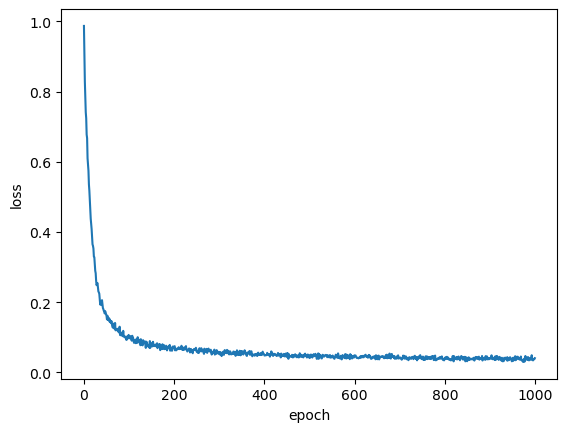

In [8]:
import matplotlib.pyplot as plt

# loss curve
loss_curve = [learning_curve[epoch]["loss"] for epoch in learning_curve]
plt.plot(loss_curve)
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'mean rank')

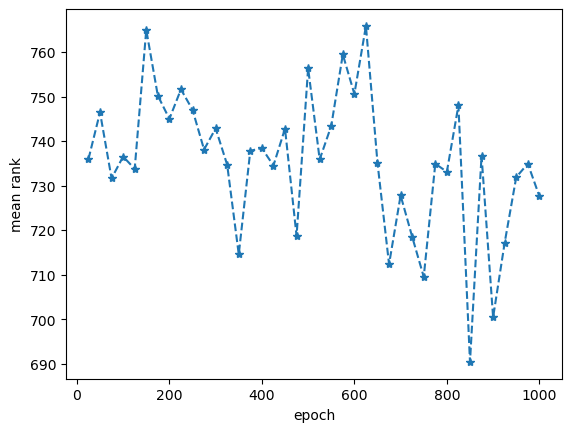

In [9]:
rank_curve = [learning_curve[epoch]["mean_rank"] for epoch in learning_curve if "mean_rank" in learning_curve[epoch]]
plt.plot([25*(i+1) for i in range(len(rank_curve))], rank_curve, '*--')
plt.xlabel("epoch")
plt.ylabel("mean rank")

Text(0, 0.5, 'hits @ 10')

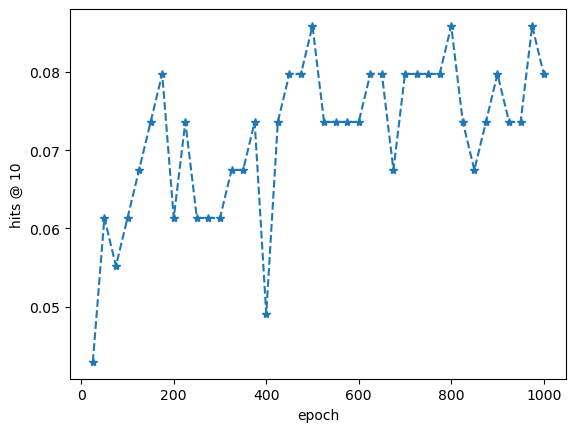

In [10]:
hits_curve = [learning_curve[epoch]["hits_at_10"] for epoch in learning_curve if "hits_at_10" in learning_curve[epoch]]
plt.plot([25*(i+1) for i in range(len(hits_curve))], hits_curve, '*--')
plt.xlabel("epoch")
plt.ylabel("hits @ 10")

In [11]:
def completion(head: str, rel: str):
    
    try:
        h = torch.tensor(node_map[head])
    except(KeyError):
        raise RuntimeError(f"'{head}' not a valid entity")
    
    try:
        r = torch.tensor(edge_map[rel])
    except(KeyError):
        raise RuntimeError(f"'{rel}' not a valid relation")

    ranked_pred = prediction(head=h, rel=r)[:10]

    print(f"Completion: {head} {rel} _____\n")
    
    for rank,(idx,score) in enumerate(ranked_pred, start=1):
        print(f"{rank:02d}: {[node for node in node_map if node_map[node] == idx][0]}")
    
    print(f'\nTrue answer(s):')
    truth = raw_df[(raw_df['subject'] == head) & (raw_df['relation'] == rel)]
    if truth['object'].values.any():
        for obj in truth['object']:
            print(f'  {obj}')
    else:
        print('\n(n/a)')



In [17]:
completion("neutron", "has charge")

Completion: neutron has charge _____

01: neutral
02: negative
03: positive
04: Positive
05: Negative
06: 0
07: negatively charged exterior
08: positive electric charge
09: no measurable electric charge
10: +2/3 e

True answer(s):
  0
  0 e
  positive
  negative


In [13]:
test_df.sample(10)

,subject,relation,object
203,nucleus,surrounds,quantum shells
374,recombination,occurs when,temperature drops below ionization potential
590,Bose–Einstein condensation,discovered in,1920s
363,immense pressure,prevents,electron shells
429,Ernest Rutherford,studied by,Hans Geiger
903,neutron,consists of,two down quarks and an up quark
1040,Neutronium,same as,bulk neutronic matter
889,Copper-64,has property,half-life
124,Quarks,part of,hadrons
208,tin,has several,stable isotopes


In [18]:
test_df[test_df["subject"] == "neutron"]

,subject,relation,object
915,neutron,consists of,proton
1000,neutron,has charge,positive
113,neutron,explained by,James Chadwick
903,neutron,consists of,two down quarks and an up quark
107,neutron,same as,proton
1142,neutron,has one,charge
1022,neutron,same as,antineutron


In [15]:
set(test_df.relation.values).intersection(set(train_df.relation.values))

{'are',
 'are found in',
 'are studied by',
 'attracts',
 'belong to',
 'belongs to',
 'can cause fission in',
 'cause',
 'caused',
 'caused by',
 'causes',
 'consists of',
 'contains',
 'defined by',
 'designated',
 'developed',
 'discovered',
 'discovered in',
 'distinguished by',
 'distinguishes',
 'emitted by',
 'explained',
 'explained by',
 'explains',
 'formed by',
 'found in',
 'has',
 'has charge',
 'has one',
 'has part',
 'has property',
 'has several',
 'has spin',
 'have',
 'is',
 'is equal to',
 'leads to',
 'measured',
 'measured by',
 'measures',
 'observed',
 'occurs when',
 'performed',
 'produce',
 'produces',
 'proposed',
 'requires',
 'same as',
 'studied by',
 'suggested',
 'surrounded by',
 'surrounds',
 'theorized',
 'type of',
 'uses'}

In [16]:
test_df.shape

(328, 3)

In [4]:
list(node_list)

['John Dalton',
 'tin oxide',
 'iron oxide',
 'nitrous oxide',
 'nitric oxide',
 'nitrogen dioxide',
 'Friedrich Wöhler',
 'Jöns Jacob Berzelius',
 'Louis Pasteur',
 "Jacobus Henricus van 't Hoff",
 'pentane',
 'carbon',
 'nitrogen',
 'oxygen',
 'composition',
 'atoms',
 'configurations',
 'isomers',
 'Robert Brown',
 'Albert Einstein',
 'Jean Perrin',
 'Brownian motion',
 'water molecules',
 'Cathode rays',
 'electrons',
 'corpuscles',
 'J. J. Thomson',
 'hydrogen',
 'electrical fields',
 'magnetic fields',
 'photoelectric materials',
 'radioactive materials',
 'electric currents',
 'metal wires',
 'Dalton',
 'Ernest Rutherford',
 'alpha particles',
 'cathode rays',
 'electric field',
 'metal',
 'foils',
 'nucleus',
 'Rutherford',
 'Frederick Soddy',
 'Margaret Todd',
 'periodic table',
 'element',
 'ionized gases',
 'stable isotopes',
 'isotope',
 'Niels Bohr',
 'model',
 'Henry Moseley',
 'Antonius van den Broek',
 'atomic number',
 'Gilbert Newton Lewis',
 'Irving Langmuir',
 'Bohr